
Eigenenergies (in eV):
  State 1: -9.702495 eV
  State 2: -9.702495 eV
  State 3: -8.814128 eV
  State 4: -8.814128 eV
  State 5: -7.349046 eV
  State 6: -7.349045 eV
  State 7: -5.338618 eV
  State 8: -5.338607 eV
  State 9: -2.858026 eV
  State 10: -2.857755 eV
States with E < 0 are bound states.



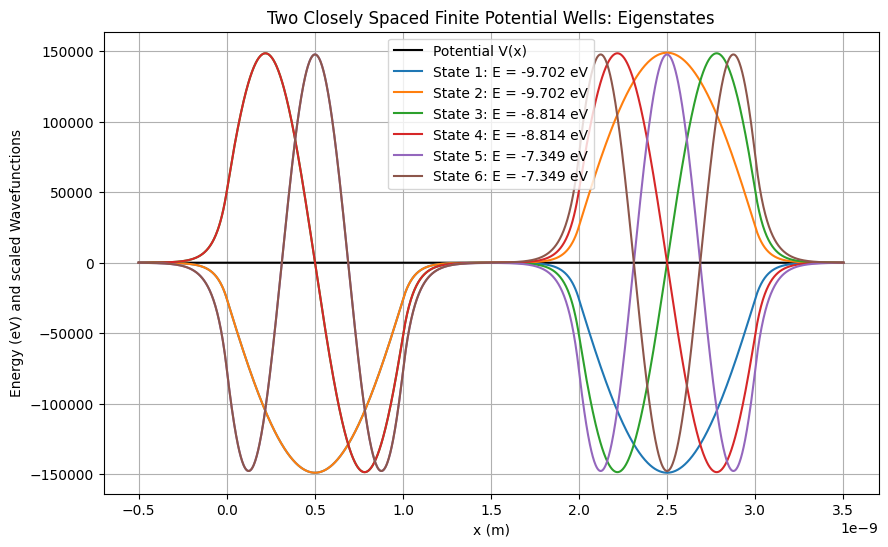

In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

def solve_double_well(mass, L, well_depth_eV, spacing, N=1500):
    """
    Solve the 1D Schrödinger equation for two closely spaced finite wells.
    
    The potential V(x) is defined as:
      - For x in [0, L]: V(x) = -V0  (first well)
      - For x in [L+spacing, 2L+spacing]: V(x) = -V0 (second well)
      - Elsewhere: V(x) = 0
      
    Parameters:
      mass          : Mass of the particle (kg)
      L             : Width of each well (m)
      well_depth_eV : Depth of the well (in eV) [V(x) = -V0 inside the wells]
      spacing       : Spacing between the two wells (m)
      N             : Number of spatial grid points (default 1500)
      
    Returns:
      energies_eV : Sorted eigenenergies (in eV)
      eigenvecs   : Corresponding eigenfunctions (each column is an eigenstate)
      x           : Spatial grid (m)
      Vx_eV       : Potential profile (in eV) on the grid
    """
    # Physical constants
    hbar = 1.054571817e-34         # Reduced Planck's constant in J*s
    eV_to_J = 1.602176634e-19      # 1 eV in Joules

    # Convert well depth from eV to Joules
    V0_J = well_depth_eV * eV_to_J

    # Define the spatial domain.
    # The first well: [0, L], second well: [L+spacing, 2L+spacing]
    # We extend the domain by 0.5L on either side so that the wavefunctions decay to ~0.
    x_min = -0.5 * L
    x_max = 2 * L + spacing + 0.5 * L
    x = np.linspace(x_min, x_max, N)
    dx = x[1] - x[0]

    # Build the potential profile V(x) (in Joules)
    Vx = np.zeros_like(x)
    for i, xi in enumerate(x):
        if 0 <= xi <= L:
            Vx[i] = -V0_J
        elif (L + spacing) <= xi <= (2 * L + spacing):
            Vx[i] = -V0_J
        else:
            Vx[i] = 0.0

    # Build the Hamiltonian using a finite-difference approximation
    # Kinetic energy operator: T = - (hbar^2)/(2m) d^2/dx^2
    # Use central differences:
    coeff = - hbar**2 / (2 * mass * dx**2)
    main_diag = -2 * coeff + Vx         # Diagonal elements include V(x)
    off_diag = coeff * np.ones(N - 1)     # Off-diagonals

    # Construct the Hamiltonian matrix (tridiagonal)
    H = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)

    # Diagonalize the Hamiltonian
    eigenvals, eigenvecs = np.linalg.eigh(H)
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]

    # Convert energies from Joules to eV
    energies_eV = eigenvals / eV_to_J

    # Normalize the eigenfunctions (discrete normalization: ∑|ψ|^2*dx ≈ 1)
    for i in range(eigenvecs.shape[1]):
        norm = np.sqrt(np.sum(np.abs(eigenvecs[:, i])**2) * dx)
        eigenvecs[:, i] /= norm

    # Convert potential to eV for plotting
    Vx_eV = Vx / eV_to_J

    return energies_eV, eigenvecs, x, Vx_eV

def main():
    # Prompt the user for input values
    try:
        mass = float(input("Enter the mass (in kg): "))
        L = float(input("Enter the width of each well (in m): "))
        well_depth_eV = float(input("Enter the depth of the well (in eV): "))
        spacing = float(input("Enter the spacing between the wells (in m): "))
    except ValueError:
        print("Invalid input! Please enter numerical values.")
        return

    # Number of spatial grid points
    N = 1500

    # Solve for the eigenstates
    energies_eV, eigenvecs, x, Vx_eV = solve_double_well(mass, L, well_depth_eV, spacing, N)

    # Print the first several eigenenergies
    print("\nEigenenergies (in eV):")
    for i, E in enumerate(energies_eV[:10], start=1):
        print(f"  State {i}: {E:.6f} eV")
    print("States with E < 0 are bound states.\n")

    # Plot the potential and a few eigenfunctions (bound states)
    plt.figure(figsize=(10, 6))
    plt.plot(x, Vx_eV, 'k-', label="Potential V(x)")

    # Identify bound states (E < 0) and plot up to 6 of them
    bound_indices = np.where(energies_eV < 0)[0]
    n_to_plot = min(len(bound_indices), 6)
    for i in range(n_to_plot):
        idx_state = bound_indices[i]
        E = energies_eV[idx_state]
        psi = eigenvecs[:, idx_state]
        # Scale and shift eigenfunction for visualization
        scale = 0.5 * abs(np.min(Vx_eV))
        y_psi = psi * scale + E
        plt.plot(x, y_psi, label=f"State {idx_state+1}: E = {E:.3f} eV")

    plt.xlabel("x (m)")
    plt.ylabel("Energy (eV) and scaled Wavefunctions")
    plt.title("Two Closely Spaced Finite Potential Wells: Eigenstates")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
